<Axes: xlabel='Time (samples)'>

<Figure size 1200x400 with 0 Axes>

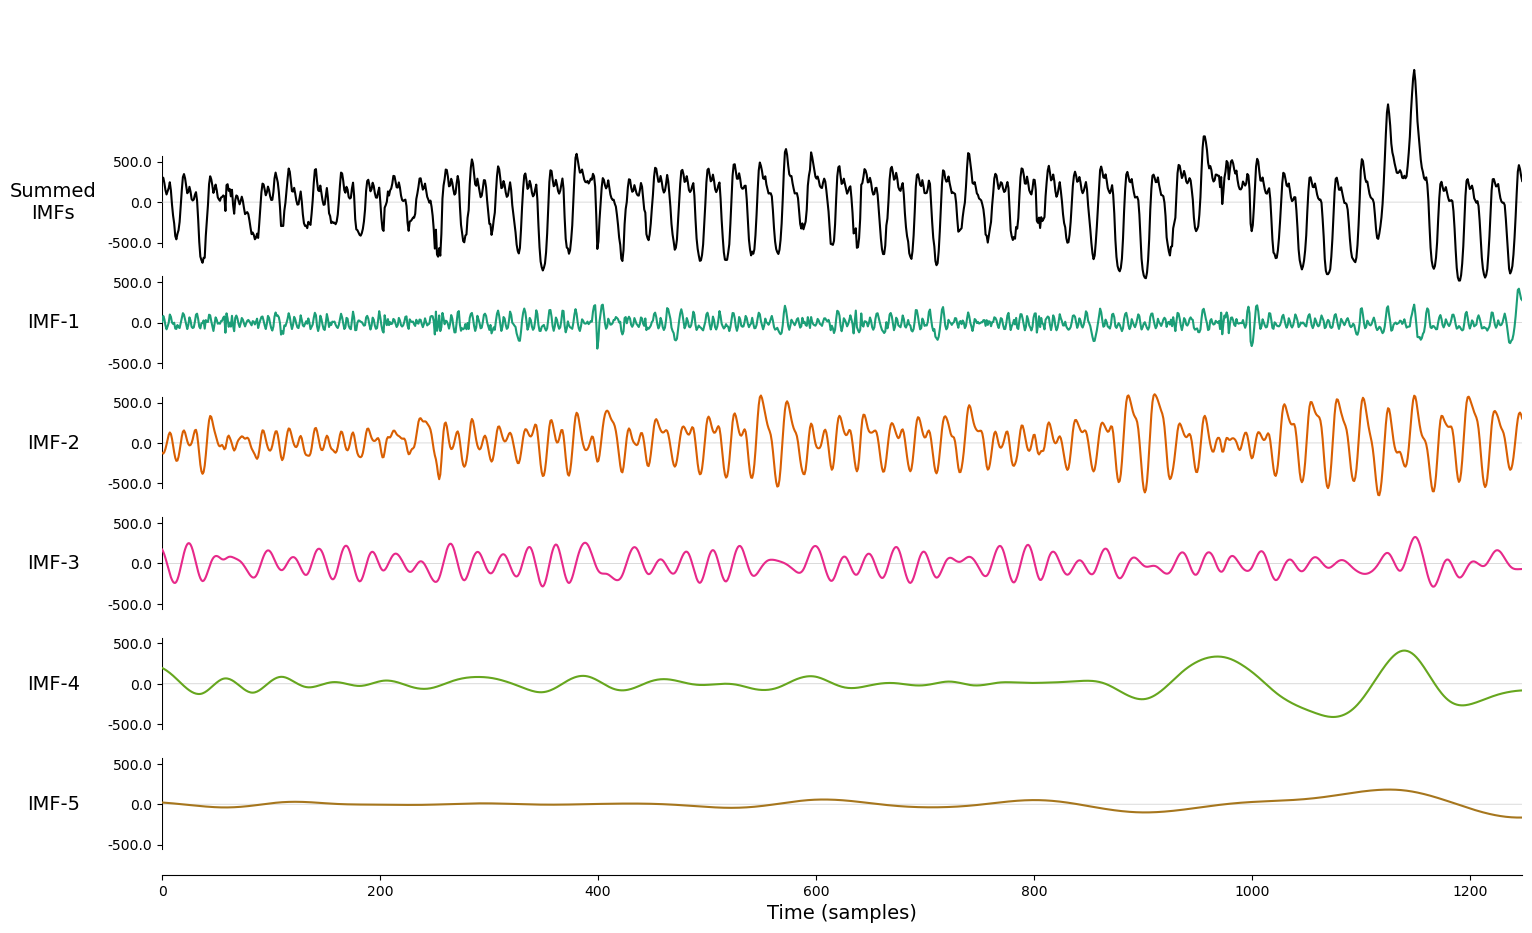

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import emd

DATA_FILEPATH = '../data/sa/merged.csv'
HOLIDAY_FILEPATH = '../data/australian-public-holidays-combined-2021-2024.csv'

holiday_df = pd.read_csv(HOLIDAY_FILEPATH, dtype='str')
holiday_df['Date'] = holiday_df['Date'].astype('datetime64[ns]')
holidays = holiday_df.loc[holiday_df['Jurisdiction'] == 'sa', ['Date', 'Holiday Name']]

df = pd.read_csv(DATA_FILEPATH)
df['datetime'] = df['datetime'].astype('datetime64')
dt = df['datetime'].dt
df['year'] = dt.year
df['month'] = dt.month
df['day'] = dt.day
df['hour'] = dt.hour
df['minute'] = dt.minute
df['dow'] = dt.day_of_week
df['week'] = dt.isocalendar().week
df['holiday'] = dt.date.isin(holidays['Date'].dt.date).astype('int')

df_train = df[df['datetime'].between('2015-01-01', '2023-01-01', inclusive='left')].reset_index(drop=True)
X_train = df_train.drop(['net_load', 'pv_est', 'total_load', 'datetime', 'minute'], axis=1)
y_train = df_train['net_load'].values

df_test = df[df['datetime'].between('2023-01-01', '2024-01-01', inclusive='left')].reset_index(drop=True)
X_test = df_test.drop(['net_load', 'pv_est', 'total_load', 'datetime', 'minute'], axis=1)
y_test = df_test['net_load'].values

imf = emd.sift.ensemble_sift(y_train, max_imfs=5, nensembles=50, ensemble_noise=0.1, nprocesses=8)

plt.figure(figsize=(12, 4))
emd.plotting.plot_imfs(imf[-1248:,:])

0.1872413859761235


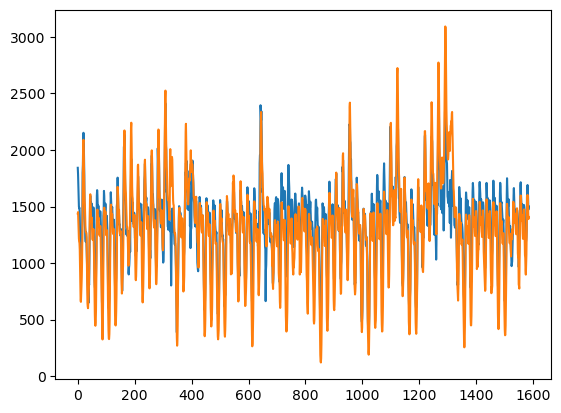

In [40]:
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor, 
    AdaBoostRegressor, HistGradientBoostingRegressor)

models = []
for y_imf in imf.transpose():
    mdl = HistGradientBoostingRegressor()
    mdl.fit(X_train, y_imf)
    models.append(mdl)

preds = np.array([mdl.predict(X_test) for mdl in models])
y_pred = preds.sum(axis=0) + np.mean(y_train)

print(np.mean(np.abs((y_pred - y_test) / y_test)))

plt.plot(y_pred)
plt.plot(y_test)

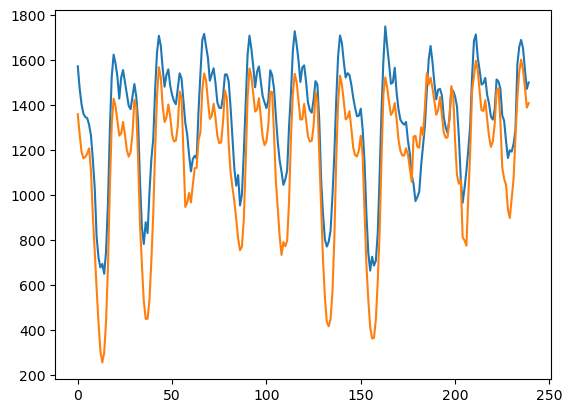

In [41]:
pt = 240
plt.plot(y_pred[-pt:])
plt.plot(y_test[-pt:])